In [70]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr
import torch
import torchvision
from pykrx import stock
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta

In [71]:
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using", device)

Using cuda


In [72]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x[:, -1])
        return x

In [73]:
seq_length = 30
stock_num = 10
Feature_num = 57
train_portion = 0.8
learning_rate = 1e-4
epoch = 500

In [74]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [0]]
        dataX.append(_x)
        dataY.append(_y)
    
    return np.array(dataX), np.array(dataY)

In [75]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [76]:
def data_load(start_date = '20190101', end_date = '20220501'):
    path = './open'
    list_name = 'Stock_List.csv'
    stock_list = pd.read_csv(os.path.join(path,list_name))
    stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
    trainX = []
    testX = []
    trainY = []
    testY = []
    testX_non_scaled = []
    testY_non_scaled = []
    for stock_code in stock_list['종목코드']:
        stock_df = stock.get_market_ohlcv_by_date(start_date, end_date, stock_code).reset_index()
        investor_df = stock.get_market_trading_volume_by_date(start_date, end_date, stock_code)[["기관합계", "외국인합계"]].reset_index()
        kospi_df = stock.get_index_ohlcv_by_date(start_date, end_date, "1001")[["종가"]].reset_index()
        stock_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
        investor_df.columns = ["Date", "inst", "fore"]
        kospi_df.columns = ["Date", "kospi"]

        tmp = pd.merge(stock_df, investor_df, how='left', on="Date")
        tmp = pd.merge(tmp, kospi_df, how='left', on="Date")

        tmp = tmp.ffill(axis=0)
        tmp = tmp.values[:, 1:].astype(np.float64)
        
        
        train_size = int(len(tmp) * train_portion)
        train_tmp = tmp[0:train_size]
        test_tmp = tmp[train_size - seq_length:]

        testX_non_scaled_tmp, testY_non_scaled_tmp = build_dataset(test_tmp, seq_length)

        train_tmp = minmax_scaler(train_tmp)
        test_tmp = minmax_scaler(test_tmp)

        trainX_tmp, trainY_tmp = build_dataset(train_tmp, seq_length)
        testX_tmp, testY_tmp = build_dataset(test_tmp, seq_length)
        
        trainX_tmp = torch.FloatTensor(trainX_tmp).to(device)
        testX_tmp = torch.FloatTensor(testX_tmp).to(device)
        testX_non_scaled_tmp = torch.FloatTensor(testX_non_scaled_tmp).to(device)
        trainY_tmp = torch.FloatTensor(trainY_tmp).to(device)
        testY_tmp = torch.FloatTensor(testY_tmp).to(device)
        testY_non_scaled_tmp = torch.FloatTensor(testY_non_scaled_tmp).to(device)

        trainX.append(trainX_tmp)
        trainY.append(trainY_tmp)
        testX.append(testX_tmp)
        testY.append(testY_tmp)
        testX_non_scaled.append(testX_non_scaled_tmp)
        testY_non_scaled.append(testY_non_scaled_tmp)
    return trainX, trainY, testX, testY, testX_non_scaled, testY_non_scaled

In [77]:
# train_dataX, train_dataY, test_dataX, test_dataY, test_data_non_scaledX, test_data_non_scaledY = data_load()

In [78]:
# 종목 코드 로드
stock_list = pd.read_csv("open/Stock_List.csv")
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x: str(x).zfill(6))


#2-- 종목명을 key로 dict(=stock_dict) 생성
stock_list.set_index("종목명", inplace=True)
selected_codes = stock_list.index.tolist()
stock_list = stock_list.loc[selected_codes]["종목코드"]
stock_dic = dict.fromkeys(selected_codes) 


#3-- 날짜 지정
start_date = '20190101'; end_date = '20211126'  # 2019 01월 01일 ~ 2021년 11월 26일 데이터 load


#4-- Original data loading
for stock_name, stock_code in tqdm(stock_list.items()):
    print("=====", stock_name, "=====")
    business_days = pd.DataFrame(pd.date_range(start_date, end_date, freq='B'), columns=['Date'])

    # 종목 주가 데이터 로드
    try:
        stock_dic[stock_name] = dict.fromkeys(["df", "target_list"])       
        # stock data
        stock_df = stock.get_market_ohlcv_by_date(start_date, end_date, stock_code).reset_index()
        # 기관합계&외국인 합계
        investor_df = stock.get_market_trading_volume_by_date(start_date, end_date, stock_code)[["기관합계", "외국인합계"]].reset_index()
        # kospi 종가
        kospi_df = stock.get_index_ohlcv_by_date(start_date, end_date, "1001")[["종가"]].reset_index()

        # columns name 변경
        stock_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
        investor_df.columns = ["Date", "inst", "fore"]
        kospi_df.columns = ["Date", "kospi"]
        business_days = business_days[business_days["Date"] >= stock_df["Date"][0]]

        # 영업일과 주가 정보를 outer 조인
        train_x = pd.merge(business_days, stock_df, how='left', on="Date")
        train_x = pd.merge(train_x, investor_df, how='left', on="Date")
        train_x = pd.merge(train_x, kospi_df, how='left', on="Date")

        # 앞의 일자로 nan값 forward fill
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].ffill(axis=0)
        # 첫 날이 na 일 가능성이 있으므로 backward fill 수행
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].bfill(axis=0)

    except:
        # 기간&외국인 합계 없는 경우
        stock_dic[stock_name] = dict.fromkeys(["df", "target_list"])
        stock_df = stock.get_market_ohlcv_by_date(start_date, end_date, stock_code).reset_index()
        kospi_df = stock.get_index_ohlcv_by_date(start_date, end_date, "1001")[["종가"]].reset_index()

        stock_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
        kospi_df.columns = ["Date", "kospi"]
        business_days = business_days[business_days["Date"] >= stock_df["Date"][0]]

        # 영업일과 주가 정보를 outer 조인
        train_x = pd.merge(business_days, stock_df, how='left', on="Date")
        train_x = pd.merge(train_x, kospi_df, how='left', on="Date")

        # 앞의 일자로 nan값 forward fill
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].ffill(axis=0)
        # 첫 날이 na 일 가능성이 있으므로 backward fill 수행
        train_x.iloc[:, 1:] = train_x.iloc[:, 1:].bfill(axis=0)
    stock_dic[stock_name]["df"] = train_x.copy()


0it [00:00, ?it/s]

===== 삼성전자 =====


1it [00:00,  1.42it/s]

===== SK하이닉스 =====


2it [00:01,  1.95it/s]

===== NAVER =====


3it [00:01,  2.21it/s]

===== 카카오 =====


4it [00:01,  2.37it/s]

===== 삼성바이오로직스 =====


5it [00:02,  2.48it/s]

===== 삼성전자우 =====


6it [00:02,  2.53it/s]

===== LG화학 =====


7it [00:02,  2.51it/s]

===== 삼성SDI =====


8it [00:03,  2.61it/s]

===== 현대차 =====


9it [00:03,  2.72it/s]

===== 셀트리온 =====


10it [00:04,  2.48it/s]


In [79]:
start_date = '2019-01-01'
end_date = '2022-05-01'
forex_index_data = yf.download(["USDKRW=X", "USDAUD=X", "USDJPY=X", "EURUSD=X", "CNY=X", "^GSPC", "^DJI", "^IXIC", "^STOXX50E",
                                "^SOX",  "000001.SS", "000300.SS", "MME=F", "^TNX"], start=start_date, end=end_date, rounding=True)

tmp_forex_index = forex_index_data["Close"]
tmp_forex_index.index = pd.to_datetime(tmp_forex_index.index)
tmp_forex_index = tmp_forex_index[(tmp_forex_index.index >= pd.to_datetime(start_date)) & (tmp_forex_index.index <= pd.to_datetime(end_date))]
tmp_forex_index.columns = ["sse_composite_index", "csi300_index", "usdtocny", "eurtousd", "msci_emerging", "usdtoaud", "usdtojpy", "usdtokrw",
                           "dow", "snp500", "nasdaq", "semicon_index", "euro50", "us10y_tsy"]

tmp_forex_index.reset_index(drop=False, inplace=True)

[*********************100%***********************]  14 of 14 completed


In [80]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [81]:
print(stock_dic)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)

{'삼성전자': {'df':           Date     Open     High      Low    Close      Volume        inst  \
0   2019-01-02  39400.0  39400.0  38550.0  38750.0   7847664.0   -545197.0   
1   2019-01-03  38300.0  38550.0  37450.0  37600.0  12471493.0  -1851235.0   
2   2019-01-04  37450.0  37600.0  36850.0  37450.0  14108958.0    895904.0   
3   2019-01-07  38000.0  38900.0  37800.0  38750.0  12748997.0   -270253.0   
4   2019-01-08  38000.0  39200.0  37950.0  38100.0  12756554.0   1334263.0   
5   2019-01-09  38650.0  39600.0  38300.0  39600.0  17452708.0     35641.0   
6   2019-01-10  40000.0  40150.0  39600.0  39800.0  14731699.0  -2554908.0   
7   2019-01-11  40350.0  40550.0  39950.0  40500.0  11661063.0   -626837.0   
8   2019-01-14  40450.0  40700.0  39850.0  40050.0  11984996.0  -2023616.0   
9   2019-01-15  40050.0  41100.0  39850.0  41100.0  11492756.0    736080.0   
10  2019-01-16  41150.0  41450.0  40700.0  41450.0   8491595.0   -478720.0   
11  2019-01-17  41700.0  42100.0  41450.0  41950

In [82]:
# ===== feature engineering =====
non_stock = []
corr_list = []
timeunit_gap_forviz = 1
metric_days = 14
cat_vars = []
bin_vars = []
cat_vars.append("weekday")
cat_vars.append("weeknum")
bin_vars.append("mfi_signal")
num_pvalue_check = None
cat_pvalue_check = pd.Series(0, index=["weekday", "weeknum", "mfi_signal"])


for stock_name, stock_data in stock_dic.items():
    train_x = stock_data["df"].copy()

    # 1. 환율 및 관련 인덱스 feature 추가
    train_x = pd.merge(train_x, tmp_forex_index, how="left", on="Date")
    train_x = train_x.ffill() # 과거 일자로 forward fill 수행    
    train_x = train_x.bfill() # 첫 날이 nan 일 가능성이 있으므로 backward fill 수행


    # 2. 요일 및 주차 파생변수 추가
    train_x['weekday'] = train_x["Date"].apply(lambda x: x.weekday())
    train_x['weeknum'] = train_x["Date"].apply(lambda x: week_of_month(x))


    # 3. 거래대금 파생변수 추가
    train_x['trading_amount'] = train_x["Close"] * train_x["Volume"]

    # 4. 월별 주기성 특징을 잡기 위한 sin 및 cos 변환 파생변수 추가
    day_to_sec = 24 * 60 * 60
    month_to_sec = 20 * day_to_sec
    timestamp_s = train_x["Date"].apply(datetime.timestamp)
    timestamp_freq = round((timestamp_s / month_to_sec).diff(20)[20], 1)
    train_x['dayofmonth_freq_sin'] = np.sin((timestamp_s / month_to_sec) * ((2 * np.pi) / timestamp_freq))
    train_x['dayofmonth_freq_cos'] = np.cos((timestamp_s / month_to_sec) * ((2 * np.pi) / timestamp_freq))


    # 5. OBV 파생변수 추가
    # 매수 신호: obv > obv_ema
    # 매도 신호: obv < obv_ema
    obv = [0]
    for i in range(1, len(train_x.Close)):
        if train_x.Close[i] >= train_x.Close[i - 1]:
            obv.append(obv[-1] + train_x.Volume[i])
        elif train_x.Close[i] < train_x.Close[i - 1]:
            obv.append(obv[-1] - train_x.Volume[i])
    train_x['obv'] = obv
    train_x['obv'][0] = np.nan
    train_x['obv_ema'] = train_x['obv'].ewm(com=metric_days, min_periods=metric_days).mean()


    # 6. Stochastic 파생변수 추가
    # fast_d = moving average on fast_k
    # stochastic 관련 지식이 없는데 함수 구현 방법을 알려주지 않아서 넘김
    # train_x[["fast_k", "fast_d"]] = stochastic(train_x, n=metric_days)[["fast_k", "fast_d"]]


    # 7. MFI 파생변수 추가
    # MFI = 100 - (100 / 1 + MFR)
    # MFR = 14일간의 양의 MF / 14일간의 음의 MF
    # MF = 거래량 * (당일고가 + 당일저가 + 당일종가) / 3
    # MF 컬럼 만들기
    train_x["mf"] = train_x["Volume"] * ((train_x["High"]+train_x["Low"]+train_x["Close"]) / 3)
    # 양의 MF와 음의 MF 표기 컬럼 만들기
    p_n = []
    for i in range(len(train_x['mf'])):
        if i == 0 :
            p_n.append(np.nan)
        else:
            if train_x['mf'][i] >= train_x['mf'][i-1]:
                p_n.append('p')
            else:
                p_n.append('n')
    train_x['p_n'] = p_n
    # 14일간 양의 MF/ 14일간 음의 MF 계산하여 컬럼 만들기
    mfr = []
    for i in range(len(train_x['mf'])):
        if i < metric_days-1:
            mfr.append(np.nan)
        else:
            train_x_=train_x.iloc[(i-metric_days+1):i]
            a = (sum(train_x_['mf'][train_x['p_n'] == 'p']) + 1) / (sum(train_x_['mf'][train_x['p_n'] == 'n']) + 10)
            mfr.append(a)
    train_x['mfr'] = mfr
    # 최종 MFI 컬럼 만들기
    train_x['mfi'] = 100 - (100 / (1 + train_x['mfr']))
    train_x["mfi_signal"] = train_x['mfi'].apply(lambda x: "buy" if x > 50 else "sell")


    # 8. 이동평균 추가
    train_x["close_mv5"] = train_x["Close"].rolling(5, min_periods=5).mean()
    train_x["close_mv10"] = train_x["Close"].rolling(10, min_periods=10).mean()
    train_x["close_mv20"] = train_x["Close"].rolling(20, min_periods=20).mean()

    train_x["volume_mv5"] = train_x["Volume"].rolling(5, min_periods=5).mean()
    train_x["volume_mv10"] = train_x["Volume"].rolling(10, min_periods=10).mean()
    train_x["volume_mv20"] = train_x["Volume"].rolling(20, min_periods=20).mean()

    train_x["trading_amount_mv5"] = train_x["trading_amount"].rolling(5, min_periods=5).mean()
    train_x["trading_amount_mv10"] = train_x["trading_amount"].rolling(10, min_periods=10).mean()
    train_x["trading_amount_mv20"] = train_x["trading_amount"].rolling(20, min_periods=20).mean()

    train_x["kospi_mv5"] = train_x["kospi"].rolling(5, min_periods=5).mean()
    train_x["kospi_mv10"] = train_x["kospi"].rolling(10, min_periods=10).mean()
    train_x["kospi_mv20"] = train_x["kospi"].rolling(20, min_periods=20).mean()

    try:
        train_x["inst_mv5"] = train_x["inst"].rolling(5, min_periods=5).mean()
        train_x["inst_mv10"] = train_x["inst"].rolling(10, min_periods=10).mean()
        train_x["inst_mv20"] = train_x["inst"].rolling(20, min_periods=20).mean()

        # 기관 연속 순매수 일자 feature 생성
        cnt_consecutive = 0
        tmp_consecutive = []
        for i in train_x["inst"]:
            if i > 0:
                cnt_consecutive += 1
            else:
                cnt_consecutive = 0
            tmp_consecutive.append(cnt_consecutive)
        train_x["consec_inst"] = tmp_consecutive

        train_x["fore_mv5"] = train_x["fore"].rolling(5, min_periods=5).mean()
        train_x["fore_mv10"] = train_x["fore"].rolling(10, min_periods=10).mean()
        train_x["fore_mv20"] = train_x["fore"].rolling(20, min_periods=20).mean()

        # 외국인 연속 순매수 일자 feature 생성
        cnt_consecutive = 0
        tmp_consecutive = []
        for i in train_x["fore"]:
            if i > 0:
                cnt_consecutive += 1
            else:
                cnt_consecutive = 0
            tmp_consecutive.append(cnt_consecutive)
        train_x["consec_fore"] = tmp_consecutive
    except:
        pass


    # 9. 과거데이터 추가
    tmp_df = pd.DataFrame()
    tmp_cols = []
    #1~5일 전 종가 load
    for i in range(1,6,1):
        tmp_df = pd.concat([tmp_df, train_x["Close"].shift(i).to_frame()], axis=1)
        tmp_cols.append("close_" + str(i) + "shift")
    tmp_df.columns = tmp_cols
    train_x = pd.concat([train_x, tmp_df], axis=1)


    # 10. columns 정리
    # 지표계산을 위해 쓰인 컬럼 drop
    train_x.drop(["mf", "p_n", "mfr"], inplace=True, axis=1)
    # 컬럼이름 소문자 변환 및 정렬
    train_x.columns = train_x.columns.str.lower()
    train_x = pd.concat([train_x[["date"]], train_x.iloc[:,1:].sort_index(axis=1)], axis=1)


    # 11. create target list
    target_list = []
    target_list.append(train_x["close"].copy())
    target_list.append(train_x["close"].shift(-1))
    target_list.append(train_x["close"].shift(-2))
    target_list.append(train_x["close"].shift(-3))
    target_list.append(train_x["close"].shift(-4))
    target_list.append(train_x["close"].shift(-5))
    for idx, value in enumerate(target_list):
        value.name = "target_shift" + str(idx)
    
    # 12. onehot encoding & df save
    # onehot_encoder = MyOneHotEncoder()
    # train_x = onehot_encoder.fit_transform(train_x, cat_vars + bin_vars)
    stock_dic[stock_name]["df"] = train_x.copy()
    stock_dic[stock_name]["target_list"] = target_list

C:\Users\ParkMinSu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
print(stock_dic['삼성전자'])
# stock_dic['주식이름']['df] -> 입력 데이터
# stock_dic['주식이름']['target_list'] -> 출력 데이터 (몇일 후의 데이터를 예측하기 위해 target_shift숫자 를 사용하기도 함)

{'df':           date    close  close_1shift  close_2shift  close_3shift  \
0   2019-01-02  38750.0           NaN           NaN           NaN   
1   2019-01-03  37600.0       38750.0           NaN           NaN   
2   2019-01-04  37450.0       37600.0       38750.0           NaN   
3   2019-01-07  38750.0       37450.0       37600.0       38750.0   
4   2019-01-08  38100.0       38750.0       37450.0       37600.0   
5   2019-01-09  39600.0       38100.0       38750.0       37450.0   
6   2019-01-10  39800.0       39600.0       38100.0       38750.0   
7   2019-01-11  40500.0       39800.0       39600.0       38100.0   
8   2019-01-14  40050.0       40500.0       39800.0       39600.0   
9   2019-01-15  41100.0       40050.0       40500.0       39800.0   
10  2019-01-16  41450.0       41100.0       40050.0       40500.0   
11  2019-01-17  41950.0       41450.0       41100.0       40050.0   
12  2019-01-18  42300.0       41950.0       41450.0       41100.0   
13  2019-01-21  42750.0    

In [95]:
for stock_name in stock_dic:
    stock_dic[stock_name]['df'] = stock_dic[stock_name]['df'].fillna(0)

print(stock_dic['삼성전자']['df'])


          date    close  close_1shift  close_2shift  close_3shift  \
0   2019-01-02  38750.0           0.0           0.0           0.0   
1   2019-01-03  37600.0       38750.0           0.0           0.0   
2   2019-01-04  37450.0       37600.0       38750.0           0.0   
3   2019-01-07  38750.0       37450.0       37600.0       38750.0   
4   2019-01-08  38100.0       38750.0       37450.0       37600.0   
5   2019-01-09  39600.0       38100.0       38750.0       37450.0   
6   2019-01-10  39800.0       39600.0       38100.0       38750.0   
7   2019-01-11  40500.0       39800.0       39600.0       38100.0   
8   2019-01-14  40050.0       40500.0       39800.0       39600.0   
9   2019-01-15  41100.0       40050.0       40500.0       39800.0   
10  2019-01-16  41450.0       41100.0       40050.0       40500.0   
11  2019-01-17  41950.0       41450.0       41100.0       40050.0   
12  2019-01-18  42300.0       41950.0       41450.0       41100.0   
13  2019-01-21  42750.0       4230

In [85]:
#i = 3
#print(train_dataX[i].shape)
#print(train_dataY[i].shpae)
#print(test_dataX[i].shape)
#print(test_dataY[i].shape)

In [ ]:
net = Net(8, 16, 1, 2).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [87]:
for i in range(epoch):
    for cur_stock in range(stock_num):
        optimizer.zero_grad()
        outputs = net(train_dataX[cur_stock]).to(device)
        loss = criterion(outputs, train_dataY[cur_stock])
        loss.backward()
        optimizer.step()
        print(i, loss.item())

0 0.2961900234222412
0 0.2590656280517578
0 0.2678848206996918
0 0.20970956981182098
0 0.31323304772377014
0 0.31737348437309265
0 0.28254234790802
0 0.2380073219537735
0 0.28549155592918396
0 0.2507396936416626
1 0.282876193523407
1 0.2464258372783661
1 0.255843847990036
1 0.19866792857646942
1 0.29969289898872375
1 0.3038630187511444
1 0.27038440108299255
1 0.22743479907512665
1 0.27212169766426086
1 0.23840650916099548
2 0.26998355984687805
2 0.23420338332653046
2 0.24422502517700195
2 0.18805058300495148
2 0.2865784168243408
2 0.2907826602458954
2 0.25865623354911804
2 0.21728630363941193
2 0.25918349623680115
2 0.2265034019947052
3 0.25752508640289307
3 0.22241026163101196
3 0.23303622007369995
3 0.1778593808412552
3 0.2738930881023407
3 0.2781345844268799
3 0.2473551332950592
3 0.2075578272342682
3 0.24667051434516907
3 0.2150212973356247
4 0.24548909068107605
4 0.211033433675766
4 0.22226226329803467
4 0.1680777668952942
4 0.2616158425807953
4 0.2658950686454773
4 0.236457154154

KeyboardInterrupt: 

In [ ]:
# non scaled
error = 0

for cur_stock in range(stock_num):
    optimizer.zero_grad()
    outputs = net(test_dataX[cur_stock]).to(device)
    error += torch.mean(torch.abs(outputs - test_dataY[cur_stock])).item() / stock_num
    
    for i in range(len(outputs)):
        print("pred :", outputs[i].item(), test_dataY[cur_stock][i].item())

print("Mean Error :", error)

pred : 0.513806939125061 0.5054945349693298
pred : 0.5289028882980347 0.5659340620040894
pred : 0.542492151260376 0.5384615659713745
pred : 0.5645118355751038 0.6373626589775085
pred : 0.5926969051361084 0.6428571343421936
pred : 0.6140793561935425 0.6208791136741638
pred : 0.6324950456619263 0.6428571343421936
pred : 0.6533342003822327 0.6593406796455383
pred : 0.6628760695457458 0.598901093006134
pred : 0.662697434425354 0.6208791136741638
pred : 0.6534294486045837 0.5604395866394043
pred : 0.6370086669921875 0.5549450516700745
pred : 0.6264172792434692 0.6593406796455383
pred : 0.6347660422325134 0.6758241653442383
pred : 0.6455333232879639 0.6703296899795532
pred : 0.6522664427757263 0.6153846383094788
pred : 0.6580892205238342 0.6813187003135681
pred : 0.6686645746231079 0.6868131756782532
pred : 0.6787233948707581 0.6703296899795532
pred : 0.6882486939430237 0.692307710647583
pred : 0.6890660524368286 0.5329670310020447
pred : 0.6597862243652344 0.5054945349693298
pred : 0.622720

pred : 78438.0703125 74300.0
pred : 78589.03125 75400.0
pred : 78724.921875 74900.0
pred : 78945.1171875 76700.0
pred : 79226.96875 76800.0
pred : 79440.796875 76400.0
pred : 79624.953125 76800.0
pred : 79833.34375 77100.0
pred : 79928.7578125 76000.0
pred : 79926.9765625 76400.0
pred : 79834.296875 75300.0
pred : 79670.0859375 75200.0
pred : 79564.171875 77100.0
pred : 79647.6640625 77400.0
pred : 79755.3359375 77300.0
pred : 79822.6640625 76300.0
pred : 79222.8046875 77500.0
pred : 79317.984375 77600.0
pred : 79408.5078125 77300.0
pred : 77635.96875 77700.0
pred : 76331.890625 74800.0
pred : 76203.0625 74300.0
pred : 76039.96875 73900.0
pred : 75838.6015625 73000.0
pred : 75462.75 72600.0
pred : 75005.1171875 71600.0
pred : 74215.4453125 72300.0
pred : 74038.734375 70700.0
pred : 73205.359375 68700.0
pred : 71530.046875 69000.0
pred : 71241.6328125 70200.0
pred : 71143.3125 70200.0
pred : 71106.15625 70800.0
pred : 71185.453125 70700.0
pred : 71288.8984375 70300.0
pred : 71368.429687

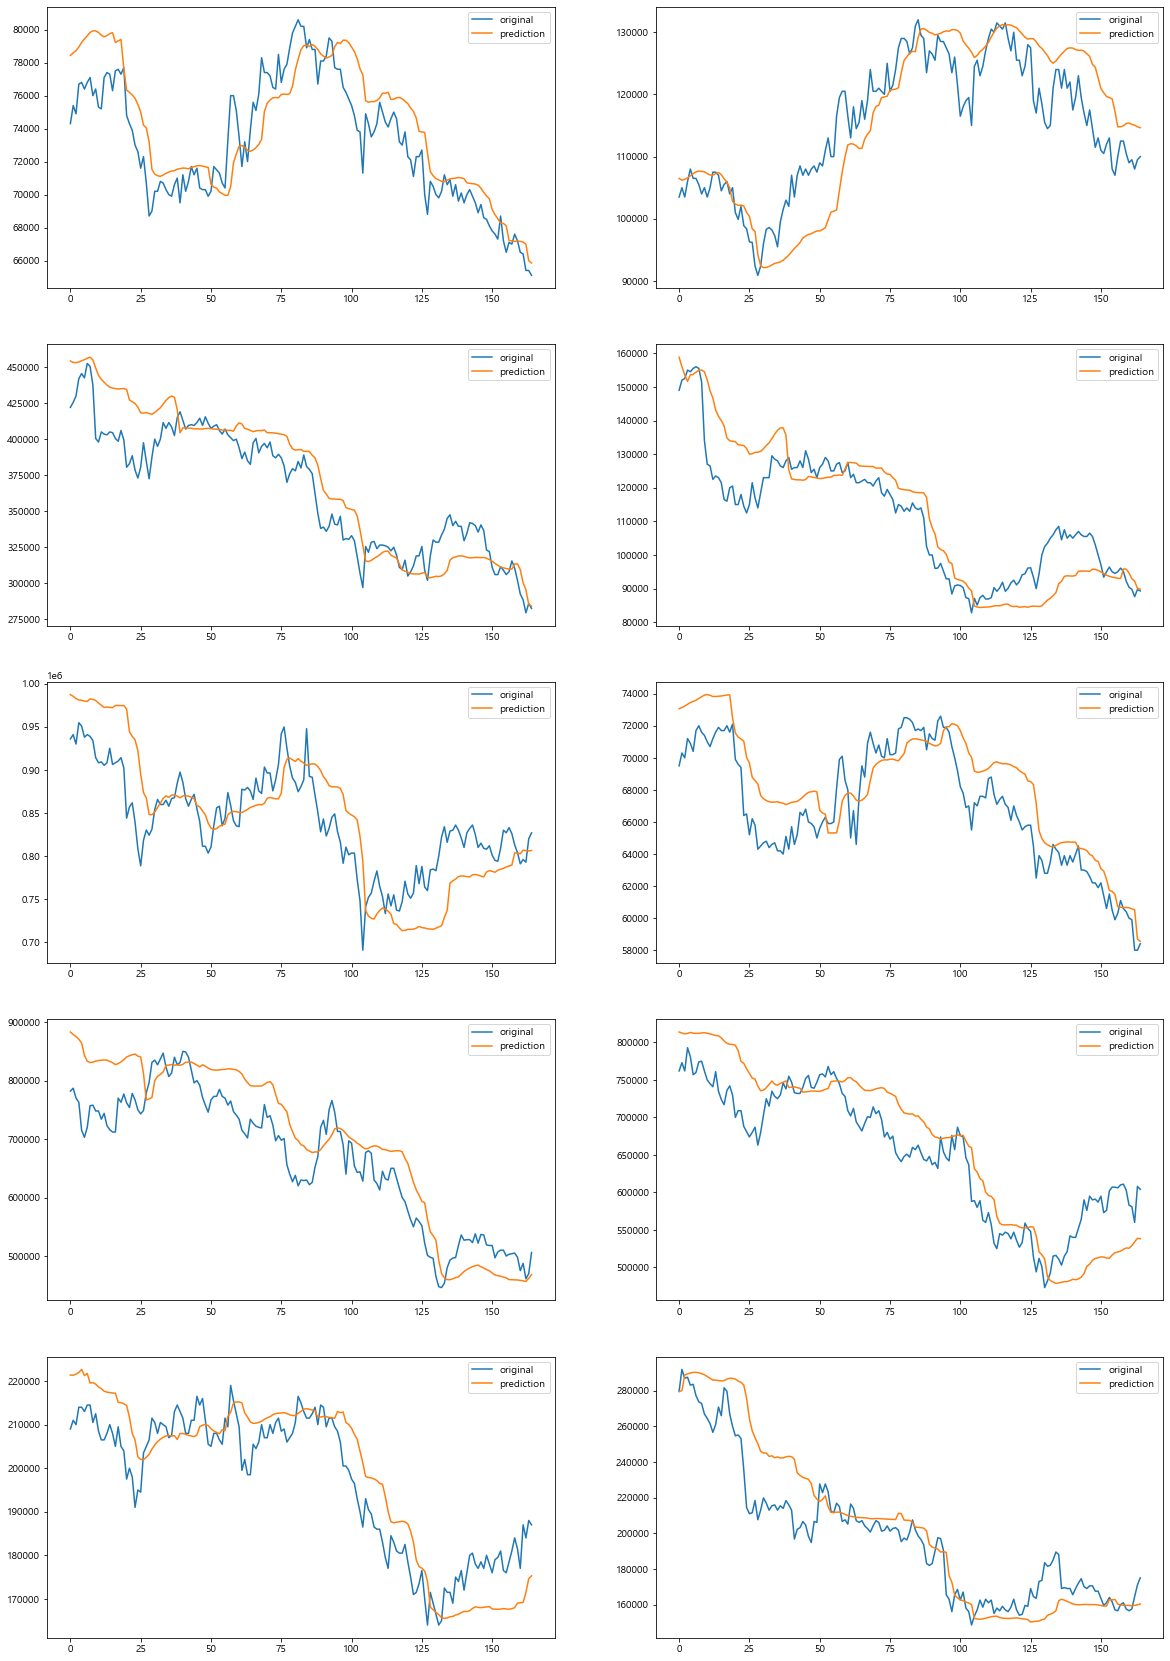

In [ ]:
# scaled
error = 0
plt.figure(figsize=(20, 30))

for cur_stock in range(stock_num):
    optimizer.zero_grad()
    outputs = net(test_dataX[cur_stock])
    max_num = torch.max(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
    min_num = torch.min(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
    outputs = (max_num - min_num) * outputs + min_num
    error += torch.mean(torch.abs(outputs - test_data_non_scaledY[cur_stock])/test_data_non_scaledY[cur_stock]).item() / stock_num
    
    for i in range(len(outputs)):
        print("pred :", outputs[i].item(), test_data_non_scaledY[cur_stock][i].item())

    plt.subplot(5, 2, cur_stock + 1)
    plt.plot(test_data_non_scaledY[cur_stock].to('cpu'))
    plt.plot(outputs.to('cpu').detach().numpy())
    plt.legend(['original', 'prediction'])
    plt.show

print("Mean Error :", error)